# RAG y RAG agentico.

**Por Exdata y el Taller de Datos Populares**

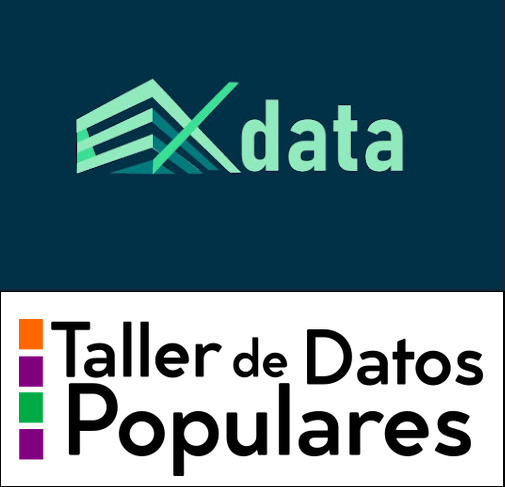

# Qué es RAG?


RAG es el acronimo para Retrival Augmented Generation por sus siglas en Ingles. Esto en español significa Generación Aumentada por Recuperación y se trata de un método rentable para mejorar los resultados de los LLM de modo que sigan siendo relevantes, precisos y útiles en diversos contextos. Es decir, no hace falta entrenar un nuevamente un modelo para una tarea especifica en particular por ejemplo (Documentación de procesos internos de una empresa.)

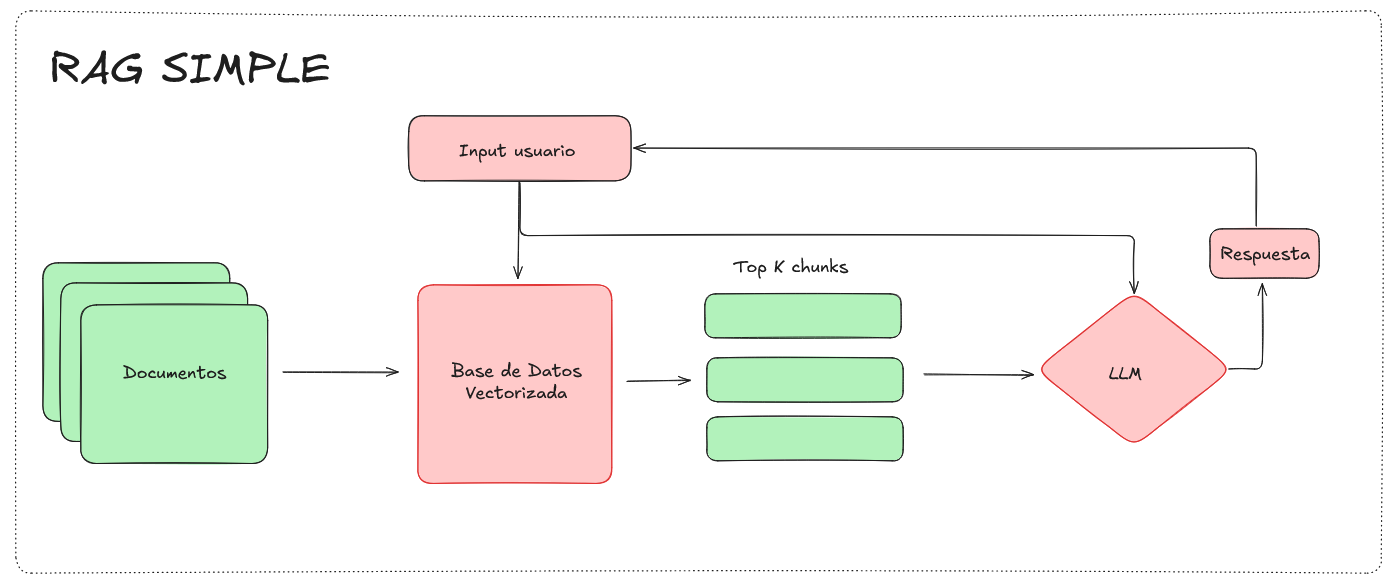

# RAG Simple

El RAG simple tiene dos partes principales:

1. **Vectorización e indexación de los documentos**
2. **Recuperación del contenido y generación de respuestas**

## Vectorización e indexación de los documentos

Los documentos son separados en pequeñas partes llamadas **chunks** (recortes) para su fácil digestión. Luego estos mismos son vectorizados mediante un modelo de procesamiento de lenguaje que toma un `string` y devuelve un vector en el espacio $\mathbb{R}^n$. Esta operación es útil para luego hacer operaciones de similitud en base al input del usuario. Seguidamente se indexan estos vectores para que sea sencillo buscarlos, utilizando algoritmos optimizados como FAISS.

De esta manera tenemos nuestra información organizada y fácil de consultar mediante la técnica de similitud (producto interno en el espacio $\mathbb{R}^n$).

## Recuperación del contenido y generación de respuestas

En la figura pueden observarse estos pasos de manera condensada (se oculta la parte del encoder que vectoriza el input del usuario):

### Paso 1: Vectorización de la consulta
El input del usuario es procesado por el mismo modelo de embeddings usado en la indexación, garantizando que tanto documentos como consulta vivan en el mismo espacio vectorial $\mathbb{R}^n$.

### Paso 2: Búsqueda por similitud
Se utiliza similitud coseno para encontrar los $k$ chunks más relevantes:
$$\text{sim}(\vec{q}, \vec{v}_i) = \frac{\vec{q} \cdot \vec{v}_i}{||\vec{q}|| \cdot ||\vec{v}_i||}$$

### Paso 3: Construcción del prompt aumentado
Los chunks recuperados se combinan con la consulta original:
```
Contexto: [Chunk 1] [Chunk 2] ... [Chunk k]
Pregunta: [Query del usuario]
Instrucción: Responde basándote en el contexto proporcionado.
```

### Paso 4: Generación
El LLM procesa el prompt aumentado y genera una respuesta fundamentada en el contexto recuperado.

**Ventajas**: Factualidad, actualización sin reentrenamiento, transparencia, costo-efectividad.

**Limitaciones**: Dependencia de la calidad del chunking, rigidez del pipeline lineal (recuperar → generar), sin capacidad de iteración o refinamiento como en sistemas agénticos más avanzados.

In [ ]:
!pip install -qU langchain langchain-community langchain-huggingface langchain-groq sentence-transformers faiss-cpu python-dotenv

print("Instalación completa - Sistema RAG listo")
print("Dependencias instaladas:")
print("- LangChain: Framework para construir aplicaciones con LLMs")
print("- LangChain-Groq: Integración con la API de Groq")
print("- Sentence-Transformers: Para crear embeddings de texto")
print("- FAISS: Biblioteca de Facebook AI para búsqueda vectorial eficiente")
print("- Python-dotenv: Para manejar variables de entorno (API keys)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from google.colab import userdata
userdata.get('GROQ_API_KEY')

'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'

In [ ]:
import os
import pandas as pd
import warnings
from getpass import getpass
warnings.filterwarnings('ignore')

# Configurar API Key de Groq
print("CONFIGURACIÓN DE GROQ API")
print("-" * 50)
print("Necesitas una API key gratuita de Groq:")
print("1. Ve a https://console.groq.com/keys")
print("2. Crea una cuenta gratuita")
print("3. Genera una API key")
print("-" * 50)

# Solicitar API key de forma segura
if 'GROQ_API_KEY' not in os.environ:
    os.environ['GROQ_API_KEY'] = getpass('Ingresa tu API Key de Groq: ')
    print("API Key configurada correctamente")
else:
    print("API Key de Groq ya configurada")

print("\nSistema listo para usar")

CONFIGURACIÓN DE GROQ API
--------------------------------------------------
Necesitas una API key gratuita de Groq:
1. Ve a https://console.groq.com/keys
2. Crea una cuenta gratuita
3. Genera una API key
--------------------------------------------------
Ingresa tu API Key de Groq: ··········
API Key configurada correctamente

Sistema listo para usar


In [ ]:
def crear_base_datos():
    """
    Crea la base de datos con información detallada de 4 superhéroes.
    Esta será nuestra fuente de conocimiento para el sistema RAG.
    """
    superheroes_data = [
        {
            "name": "Wonder Woman",
            "real_name": "Diana Prince",
            "powers_text": "Wonder Woman posee fuerza sobrehumana, velocidad, resistencia y durabilidad excepcionales. Puede volar a altas velocidades y tiene el Lazo de la Verdad, que obliga a cualquiera atado por él a decir la verdad absoluta. Sus brazaletes indestructibles pueden desviar balas y explosiones de energía. También tiene sentidos mejorados, resistencia telepática y habilidades de combate expertas con varias armas.",
            "history_text": "Diana Prince es una princesa amazona de la isla oculta de Themyscira. Fue esculpida en arcilla por su madre, la Reina Hipólita, y le dieron vida los dioses griegos. Dejó su pacífica isla para ayudar a luchar en la Primera Guerra Mundial junto a Steve Trevor, y más tarde se convirtió en uno de los miembros fundadores de la Liga de la Justicia. Sirve como embajadora entre el mundo de los hombres y las Amazonas.",
            "alignment": "Héroe",
            "intelligence_score": 88,
            "strength_score": 95,
            "location": "Themyscira, Washington DC"
        },
        {
            "name": "Batman",
            "real_name": "Bruce Wayne",
            "powers_text": "Batman no tiene poderes sobrehumanos pero posee inteligencia excepcional, habilidades de detective de clase mundial, experiencia en artes marciales a nivel maestro y acceso a tecnología avanzada. Utiliza varios dispositivos de alta tecnología, incluido el Batitraje, Batarangs, pistolas de agarre y el Batimóvil. Sus mayores activos son su mente estratégica, su inmensa riqueza y su determinación inquebrantable.",
            "history_text": "Bruce Wayne presenció el brutal asesinato de sus padres Thomas y Martha Wayne cuando era niño en el Callejón del Crimen de Ciudad Gótica. Este evento traumático lo llevó a dedicar su vida a combatir el crimen. Pasó años entrenando su cuerpo y mente hasta la condición humana máxima, estudiando artes marciales, trabajo de detective y diversas ciencias. Opera desde la Baticueva debajo de la Mansión Wayne y lidera la familia de vigilantes Bat.",
            "alignment": "Héroe",
            "intelligence_score": 100,
            "strength_score": 26,
            "location": "Ciudad Gótica"
        },
        {
            "name": "Spider-Man",
            "real_name": "Peter Parker",
            "powers_text": "Spider-Man tiene fuerza, velocidad, agilidad y reflejos sobrehumanos proporcionales a una araña. Puede adherirse a paredes y techos, tiene un 'sentido arácnido' que le advierte del peligro inminente y puede disparar telarañas desde lanzadores mecánicos en sus muñecas. También tiene curación mejorada, visión nocturna y habilidades acrobáticas increíbles.",
            "history_text": "Peter Parker era un tímido estudiante de secundaria que fue mordido por una araña radioactiva durante una exhibición científica. Inicialmente, usó sus poderes para beneficio personal, pero después de que su amado tío Ben fuera asesinado por un criminal que Peter podría haber detenido antes, aprendió que 'un gran poder conlleva una gran responsabilidad'. Se convirtió en Spider-Man para proteger la ciudad de Nueva York y sus ciudadanos.",
            "alignment": "Héroe",
            "intelligence_score": 90,
            "strength_score": 55,
            "location": "Nueva York"
        },
        {
            "name": "The Joker",
            "real_name": "Desconocido",
            "powers_text": "El Joker no tiene poderes sobrehumanos pero posee inteligencia excepcional enfocada en el caos y esquemas criminales. Tiene conocimiento experto en química, lo que le permite crear toxinas mortales y gas de la risa. Es impredecible, tiene alta tolerancia al dolor y parece ser inmune a la mayoría de las formas de análisis psicológico. Su arma más grande es su completa locura y falta de restricciones morales.",
            "history_text": "El verdadero origen del Joker sigue siendo un misterio, con múltiples historias contradictorias sobre su pasado. La versión más común sugiere que era un comediante fracasado que recurrió al crimen y cayó en una tina de desechos químicos, lo que blanqueó su piel, volvió su cabello verde y lo volvió completamente loco. Se convirtió en el mayor enemigo de Batman, representando el caos y la anarquía contra el orden y la justicia de Batman.",
            "alignment": "Villano",
            "intelligence_score": 85,
            "strength_score": 15,
            "location": "Ciudad Gótica"
        }
    ]

    return pd.DataFrame(superheroes_data)

# Crear base de datos
df = crear_base_datos()
print(f"Base de datos creada con {len(df)} superhéroes")
print("\nSuperhéroes disponibles:")
for _, hero in df.iterrows():
    print(f"- {hero['name']} ({hero['real_name']}) - {hero['alignment']}")

Base de datos creada con 4 superhéroes

Superhéroes disponibles:
- Wonder Woman (Diana Prince) - Héroe
- Batman (Bruce Wayne) - Héroe
- Spider-Man (Peter Parker) - Héroe
- The Joker (Desconocido) - Villano


In [ ]:
def preparar_corpus(df):
    """
    Convierte la base de datos en texto estructurado para el sistema RAG.
    El formato estructurado facilita la extracción de información relevante.
    """
    superhero_texts = []

    for _, hero in df.iterrows():
        hero_text = f"""SUPERHÉROE: {hero['name']}
NOMBRE REAL: {hero['real_name']}
ALINEACIÓN: {hero['alignment']}
UBICACIÓN: {hero['location']}

PODERES Y HABILIDADES:
{hero['powers_text']}

ORIGEN E HISTORIA:
{hero['history_text']}

ESTADÍSTICAS:
- Inteligencia: {hero['intelligence_score']}/100
- Fuerza: {hero['strength_score']}/100"""

        superhero_texts.append(hero_text)

    # Unir todos los textos con separadores claros
    separator = "\n\n" + "="*80 + "\n\n"
    corpus = separator.join(superhero_texts)

    return corpus, superhero_texts

corpus, superhero_texts = preparar_corpus(df)
print(f"Corpus preparado: {len(corpus):,} caracteres")
print(f"Número de documentos: {len(superhero_texts)}")

Corpus preparado: 4,340 caracteres
Número de documentos: 4


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def dividir_texto(corpus):
    """
    Divide el corpus en chunks (fragmentos) manejables para el sistema RAG.

    ¿Por qué dividir el texto?
    - Los modelos tienen límites de tokens
    - Chunks más pequeños = búsquedas más precisas
    - Mejor rendimiento en recuperación de información

    RecursiveCharacterTextSplitter: Divide texto respetando la estructura jerárquica
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,      # Reducido para evitar exceder límite de tokens
        chunk_overlap=200,   # Reducido proporcionalmente
        length_function=len,
        separators=[
            "\n\n" + "="*80 + "\n\n",     # Separador entre superhéroes
            "\n\nSUPERHÉROE:",            # Inicio de cada superhéroe
            "\n\nPODERES Y HABILIDADES:", # Sección de poderes
            "\n\nORIGEN E HISTORIA:",     # Sección de historia
            "\n\nESTADÍSTICAS:",          # Sección de estadísticas
            "\n\n",                       # Párrafos
            "\n",                         # Líneas
            ". ",                         # Oraciones
            " "                           # Palabras
        ]
    )

    # Crear documentos a partir del corpus
    docs = text_splitter.create_documents([corpus])

    # Filtrar chunks para mantener solo los más informativos
    useful_docs = []
    for doc in docs:
        content = doc.page_content.strip()
        # Mantener solo chunks con información sustancial
        if len(content) > 50 and any(keyword in content for keyword in ["SUPERHÉROE:", "PODERES", "ORIGEN", "ESTADÍSTICAS"]):
            useful_docs.append(doc)

    return useful_docs

docs_processed = dividir_texto(corpus)
print(f"Texto dividido en {len(docs_processed)} chunks útiles")
print(f"Tamaño promedio por chunk: {sum(len(doc.page_content) for doc in docs_processed) // len(docs_processed)} caracteres")

# Mostrar ejemplo de chunk
print("\nEjemplo de chunk procesado:")
print("-" * 50)
print(docs_processed[0].page_content[:300] + "...")

Texto dividido en 7 chunks útiles
Tamaño promedio por chunk: 583 caracteres

Ejemplo de chunk procesado:
--------------------------------------------------
SUPERHÉROE: Wonder Woman
NOMBRE REAL: Diana Prince
ALINEACIÓN: Héroe
UBICACIÓN: Themyscira, Washington DC...


In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

def crear_embeddings():
    """
    Crea el modelo de embeddings para convertir texto en vectores numéricos.

    ¿Qué son los embeddings?
    - Representación numérica del significado del texto
    - Textos similares tienen vectores cercanos en el espacio
    - Permiten búsqueda semántica (por significado, no solo palabras clave)

    Usamos 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':
    - Modelo multilingüe optimizado para español
    - Tamaño compacto (120MB) ideal para Colab
    - Excelente balance entre calidad y velocidad
    """
    model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    # model_kwargs = {'device': device}
    encode_kwargs = {'normalize_embeddings': True}  # Normalizar para mejor comparación

    embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        # model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

    return embeddings

print("Cargando modelo de embeddings multilingüe...")
embeddings = crear_embeddings()
# print(f"Modelo de embeddings cargado en {device}")

# Probar embeddings con ejemplos
test_queries = [
    "¿Qué superhéroe tiene poderes de araña?",
    "¿Quién es el más inteligente?"
]

print("\nPrueba de embeddings:")
for query in test_queries:
    embedding = embeddings.embed_query(query)
    print(f"- '{query}' → Vector de {len(embedding)} dimensiones")

Cargando modelo de embeddings multilingüe...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Prueba de embeddings:
- '¿Qué superhéroe tiene poderes de araña?' → Vector de 384 dimensiones
- '¿Quién es el más inteligente?' → Vector de 384 dimensiones


In [ ]:
from langchain_community.vectorstores import FAISS

def crear_vectorstore(docs, embeddings):
    """
    Crea la base de datos vectorial para búsqueda semántica eficiente.

    FAISS (Facebook AI Similarity Search):
    - Biblioteca optimizada para búsqueda de similitud en vectores
    - Puede manejar millones de vectores eficientemente
    - Soporta búsquedas aproximadas para mayor velocidad

    El vectorstore almacena:
    1. Los documentos originales
    2. Sus embeddings correspondientes
    3. Un índice para búsqueda rápida
    """
    print("Creando vectorstore con FAISS...")
    vectorstore = FAISS.from_documents(docs, embeddings)
    print("Vectorstore creado exitosamente")
    return vectorstore

vectorstore = crear_vectorstore(docs_processed, embeddings)
print(f"Base de datos vectorial lista con {len(docs_processed)} documentos indexados")

Creando vectorstore con FAISS...
Vectorstore creado exitosamente
Base de datos vectorial lista con 7 documentos indexados


In [ ]:
def probar_busqueda(vectorstore, consultas):
    """
    Demuestra cómo funciona la búsqueda semántica en nuestro vectorstore.

    La búsqueda semántica:
    - Encuentra documentos por significado, no solo palabras exactas
    - Calcula similitud coseno entre vectores de consulta y documentos
    - Retorna los documentos más relevantes con sus puntuaciones
    """
    print("DEMOSTRACIÓN DE BÚSQUEDA SEMÁNTICA")
    print("="*60)

    for i, consulta in enumerate(consultas, 1):
        print(f"\nPRUEBA {i}: {consulta}")
        print("-" * 60)

        # Buscar los 2 documentos más relevantes con puntuación
        results = vectorstore.similarity_search_with_score(consulta, k=2)

        for j, (doc, score) in enumerate(results):
            content = doc.page_content

            # Extraer nombre del superhéroe si está presente
            if "SUPERHÉROE:" in content:
                hero_name = content.split("SUPERHÉROE:")[1].split("\n")[0].strip()
                print(f"  {j+1}. {hero_name} (Similitud: {1-score:.3f})")
            else:
                print(f"  {j+1}. Fragmento (Similitud: {1-score:.3f})")

            # Mostrar vista previa del contenido
            preview = content[:150].replace('\n', ' ')
            print(f"     Vista previa: {preview}...")

# Consultas de prueba que demuestran capacidades semánticas
consultas_prueba = [
    "¿Qué superhéroe puede volar y tiene un lazo mágico?",
    "¿Quién es el más inteligente de todos?",
    "¿Qué personaje trepa por las paredes?",
    "¿Cuál es el villano principal de Batman?"
]

probar_busqueda(vectorstore, consultas_prueba)

DEMOSTRACIÓN DE BÚSQUEDA SEMÁNTICA

PRUEBA 1: ¿Qué superhéroe puede volar y tiene un lazo mágico?
------------------------------------------------------------
  1. Fragmento (Similitud: 0.234)
     Vista previa: PODERES Y HABILIDADES: Wonder Woman posee fuerza sobrehumana, velocidad, resistencia y durabilidad excepcionales. Puede volar a altas velocidades y ti...
  2. Fragmento (Similitud: 0.230)
     Vista previa: PODERES Y HABILIDADES: Batman no tiene poderes sobrehumanos pero posee inteligencia excepcional, habilidades de detective de clase mundial, experienci...

PRUEBA 2: ¿Quién es el más inteligente de todos?
------------------------------------------------------------
  1. Fragmento (Similitud: -0.347)
     Vista previa: PODERES Y HABILIDADES: El Joker no tiene poderes sobrehumanos pero posee inteligencia excepcional enfocada en el caos y esquemas criminales. Tiene con...
  2. Fragmento (Similitud: -0.417)
     Vista previa: PODERES Y HABILIDADES: Batman no tiene poderes sobrehu

In [ ]:
from langchain_groq import ChatGroq

def crear_modelo_groq():
    """
    Crea el modelo de generación usando la API de Groq.

    Ventajas de usar Groq:
    - Extremadamente rápido (hasta 10x más rápido que otras APIs)
    - Sin límites estrictos de tokens como los modelos locales
    - Modelos de alta calidad (Llama, Mixtral, etc.)
    - API gratuita con límites generosos
    - Excelente soporte para español

    Usamos Mixtral-8x7b:
    - Modelo multilingüe de alta calidad
    - Excelente rendimiento en español
    - Contexto de 32k tokens
    - Respuestas rápidas y precisas
    """
    print("Configurando modelo Groq...")

    # Crear instancia del modelo
    llm = ChatGroq(
        model="llama-3.3-70b-versatile",  # Modelo Mixtral con 32k tokens de contexto
        temperature=0.3,              # Baja temperatura para respuestas más precisas
        max_tokens=500,               # Respuestas más completas sin límites estrictos
    )

    print("Modelo Groq configurado exitosamente")
    print("- Modelo: Mixtral 8x7B")
    print("- Contexto: 32,768 tokens")
    print("- Sin problemas de longitud de entrada")

    return llm

# Crear modelo
llm = crear_modelo_groq()

# Probar el modelo
print("\nPrueba rápida del modelo:")
respuesta = llm.invoke("Di 'Hola, estoy funcionando correctamente' en español")
print(respuesta.content)


Configurando modelo Groq...
Modelo Groq configurado exitosamente
- Modelo: Mixtral 8x7B
- Contexto: 32,768 tokens
- Sin problemas de longitud de entrada

Prueba rápida del modelo:
¡Hola! Estoy funcionando correctamente. ¿En qué puedo ayudarte?


In [ ]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

def crear_cadena_rag(llm, vectorstore):
    """
    Crea la cadena RAG completa que combina recuperación y generación.

    LangChain nos proporciona:
    - RetrievalQA: Cadena que combina búsqueda y generación
    - PromptTemplate: Plantillas reutilizables para prompts
    - Integración sencilla entre componentes

    Flujo del sistema RAG:
    1. Usuario hace una pregunta
    2. Se buscan documentos relevantes en el vectorstore
    3. Se construye un prompt con contexto + pregunta
    4. El LLM genera una respuesta basada en el contexto

    Con Groq podemos usar prompts más detallados sin preocuparnos por límites
    """

    # Template de prompt detallado - sin límites con Groq
    template = """Eres un experto en superhéroes que responde preguntas en español.

INFORMACIÓN DISPONIBLE:
{context}

PREGUNTA DEL USUARIO: {question}

INSTRUCCIONES:
1. Responde ÚNICAMENTE basándote en la información proporcionada arriba
2. Si la información solicitada no está en el contexto, responde: "No tengo esa información en mi base de datos"
3. Sé específico y menciona nombres de superhéroes cuando sea relevante
4. Incluye detalles importantes como poderes, origen o estadísticas cuando sean relevantes
5. Mantén un tono amigable y educativo

RESPUESTA:"""

    # Crear prompt template
    prompt = PromptTemplate(
        template=template,
        input_variables=["context", "question"]
    )

    # Configurar retriever para obtener los 3 documentos más relevantes
    retriever = vectorstore.as_retriever(
        search_kwargs={"k": 2}  # Podemos usar más documentos sin problemas
    )

    # Crear cadena RAG
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",  # "stuff" = incluir todos los docs en el prompt
        retriever=retriever,
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=True,
        verbose=False  # Cambiar a True para ver el proceso interno
    )

    return qa_chain

print("Construyendo cadena RAG...")
qa_chain = crear_cadena_rag(llm, vectorstore)
print("Sistema RAG completo y listo para usar")

Construyendo cadena RAG...
Sistema RAG completo y listo para usar


In [ ]:
def consultar_superheroes(pregunta, mostrar_fuentes=True):
    """
    Función principal para hacer consultas al sistema RAG.

    Proceso completo:
    1. Recibe pregunta del usuario
    2. Busca documentos relevantes
    3. Genera respuesta contextualizada
    4. Muestra fuentes consultadas
    """
    print(f"\nPREGUNTA: {pregunta}")
    print("-" * 70)

    # Ejecutar consulta RAG
    resultado = qa_chain.invoke({"query": pregunta})

    # Mostrar respuesta generada
    print("\nRESPUESTA:")
    print(resultado['result'])

    # Mostrar fuentes si se solicita
    if mostrar_fuentes and 'source_documents' in resultado:
        print(f"\nFUENTES CONSULTADAS ({len(resultado['source_documents'])} documentos):")

        heroes_mencionados = set()
        for i, doc in enumerate(resultado['source_documents'], 1):
            content = doc.page_content
            if "SUPERHÉROE:" in content:
                hero_name = content.split("SUPERHÉROE:")[1].split("\n")[0].strip()
                heroes_mencionados.add(hero_name)

        for hero in sorted(heroes_mencionados):
            print(f"  • {hero}")

    return resultado['result']

In [ ]:
print("DEMOSTRACIÓN DEL SISTEMA RAG DE SUPERHÉROES")
print("=" * 70)
print("El sistema combina:")
print("1. Búsqueda semántica para encontrar información relevante")
print("2. Generación de texto para crear respuestas naturales")
print("3. Todo el conocimiento está basado en nuestra base de datos")
print("=" * 70)

# Preguntas de demostración que muestran diferentes capacidades
preguntas_demo = [
    "¿Cuáles son los poderes principales de Spider-Man?",
    "¿Por qué Bruce Wayne se convirtió en Batman?",
    "¿Qué superhéroe es una princesa amazona?",
    "Compara la inteligencia de Batman y Spider-Man",
    "¿Dónde vive el Joker y cuál es su relación con Batman?"
]

for pregunta in preguntas_demo:
    consultar_superheroes(pregunta)
    print("\n" + "="*70 + "\n")

DEMOSTRACIÓN DEL SISTEMA RAG DE SUPERHÉROES
El sistema combina:
1. Búsqueda semántica para encontrar información relevante
2. Generación de texto para crear respuestas naturales
3. Todo el conocimiento está basado en nuestra base de datos

PREGUNTA: ¿Cuáles son los poderes principales de Spider-Man?
----------------------------------------------------------------------

RESPUESTA:
¡Hola! Me alegra que estés interesado en conocer más sobre el increíble Spider-Man.

Los poderes principales de Spider-Man son:

* Fuerza, velocidad, agilidad y reflejos sobrehumanos proporcionales a una araña
* Capacidad para adherirse a paredes y techos
* Un "sentido arácnido" que le advierte del peligro inminente
* Puede disparar telarañas desde lanzadores mecánicos en sus muñecas
* Curación mejorada
* Visión nocturna
* Habilidades acrobáticas increíbles

Estos poderes son el resultado de la mordedura de una araña radioactiva que recibió durante una exhibición científica, lo que cambió su vida para siempre

In [ ]:
def analizar_rendimiento_rag():
    """
    Analiza y explica el rendimiento del sistema RAG
    """
    print("ANÁLISIS DEL SISTEMA RAG")
    print("=" * 50)

    # Información sobre componentes
    print("\nCOMPONENTES DEL SISTEMA:")
    print(f"1. Base de conocimiento: {len(df)} superhéroes")
    print(f"2. Documentos procesados: {len(docs_processed)} chunks")
    print(f"3. Tamaño de embeddings: 384 dimensiones")

    # Ventajas del enfoque RAG
    print("\nVENTAJAS DEL ENFOQUE RAG:")
    print("• Respuestas basadas en datos verificados")
    print("• No hay alucinaciones (información inventada)")
    print("• Fácil actualización de la base de conocimiento")
    print("• Transparencia en las fuentes de información")

    # Casos de uso
    print("\nCASOS DE USO IDEALES:")
    print("• Chatbots de atención al cliente")
    print("• Sistemas de preguntas y respuestas empresariales")
    print("• Asistentes virtuales especializados")
    print("• Búsqueda semántica en documentación")

analizar_rendimiento_rag()

In [ ]:
def consulta_interactiva():
    """
    Interfaz interactiva para que el usuario haga preguntas
    """
    print("\nSISTEMA RAG DE SUPERHÉROES - MODO INTERACTIVO")
    print("=" * 50)
    print("Haz preguntas sobre Wonder Woman, Batman, Spider-Man o Joker")
    print("Escribe 'salir' para terminar")
    print("=" * 50)

    while True:
        pregunta = input("\n¿Cuál es tu pregunta? ")

        if pregunta.lower() in ['salir', 'exit', 'quit']:
            print("Gracias por usar el sistema RAG. ¡Hasta pronto!")
            break

        if pregunta.strip():
            consultar_superheroes(pregunta, mostrar_fuentes=True)
        else:
            print("Por favor, escribe una pregunta válida.")

# Para activar el modo interactivo, ejecuta:
consulta_interactiva()


SISTEMA RAG DE SUPERHÉROES - MODO INTERACTIVO
Haz preguntas sobre Wonder Woman, Batman, Spider-Man o Joker
Escribe 'salir' para terminar

¿Cuál es tu pregunta? Quien tiene lazo magico? 

PREGUNTA: Quien tiene lazo magico? 
----------------------------------------------------------------------

RESPUESTA:
La pregunta es sobre quién tiene el lazo mágico. Según la información proporcionada, Wonder Woman es la que posee el Lazo de la Verdad, que es un lazo mágico que obliga a cualquiera atado por él a decir la verdad absoluta. Este lazo es una de las herramientas más emblemáticas y poderosas de Wonder Woman, y es un reflejo de su compromiso con la justicia y la verdad.

Así que, para responder a tu pregunta, es Wonder Woman quien tiene el lazo mágico, específicamente el Lazo de la Verdad. Este lazo es una parte integral de sus habilidades y poderes, y es una de las razones por las que es considerada una de las superheroínas más poderosas y respetadas en el universo de los superhéroes.

FU

In [ ]:
print("\nCONCEPTOS CLAVE APRENDIDOS")
print("=" * 50)

print("\n1. RAG (Retrieval-Augmented Generation):")
print("   - Combina búsqueda de información con generación de texto")
print("   - Evita alucinaciones al basarse en datos reales")
print("   - Ideal para dominios específicos con información verificada")

print("\n2. Embeddings:")
print("   - Representación vectorial del significado del texto")
print("   - Permiten búsqueda semántica eficiente")
print("   - Modelo multilingüe para mejor soporte en español")

print("\n3. Vector Store (FAISS):")
print("   - Base de datos optimizada para vectores")
print("   - Búsqueda rápida por similitud")
print("   - Escalable a millones de documentos")

print("\n4. LangChain:")
print("   - Framework que simplifica la construcción de aplicaciones LLM")
print("   - Integra fácilmente diferentes componentes")
print("   - Proporciona abstracciones útiles como RetrievalQA")

print("\n5. Chunking:")
print("   - División inteligente de documentos largos")
print("   - Mejora la precisión de búsqueda")
print("   - Respeta la estructura del contenido")